# Build and Train

In [1]:
import tensorflow as tf
from boltzmann.data.mnist import load_mnist
from boltzmann.generic.base import State, train
from boltzmann.generic.bernoulli import (
    BernoulliBoltzmannMachine, HintonInitializer, LogInternalInformation,
    initialize_fantasy_state, get_reconstruction_error)

IMAGE_SIZE = (16, 16)
SEED = 42

tf.random.set_seed(SEED)

In [2]:
(X, y), _ = load_mnist(image_size=IMAGE_SIZE, binarize=True,
                       minval=0, maxval=1)

ambient_size = IMAGE_SIZE[0] * IMAGE_SIZE[1]
latent_size = 64
batch_size = 128
epochs = 30
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset = dataset.shuffle(10000).repeat(epochs).batch(batch_size)
bm = BernoulliBoltzmannMachine(
    ambient_size=ambient_size,
    latent_size=latent_size,
    initializer=HintonInitializer(X),
    max_step=100,
    tolerance=1e-1,
    connect_ambient_to_ambient=False,
    sync_ratio=0.25,
    seed=SEED,
)
fantasy_state = initialize_fantasy_state(bm, batch_size, SEED)
optimizer = tf.optimizers.Adam()
callbacks = [LogInternalInformation(bm, log_step=100, verbose=True)]
fantasy_state = train(bm, optimizer, dataset, fantasy_state, callbacks=callbacks)

.43384 (0.49560) - ambient_latent_kernel:0: -0.06124 (0.31224) - ambient_bias:0: -5.97618 (6.27400) - latent_bias:0: 0.02651 (0.13994) - latent_latent_kernel:0: 0.00823 (0.15379) - recon_error: 0.07379
step: 5500 - real_latent: 0.43628 (0.49592) - ambient_latent_kernel:0: -0.06204 (0.31581) - ambient_bias:0: -5.97645 (6.27369) - latent_bias:0: 0.02756 (0.14130) - latent_latent_kernel:0: 0.00863 (0.15554) - recon_error: 0.07169
step: 5600 - real_latent: 0.42249 (0.49396) - ambient_latent_kernel:0: -0.06198 (0.31958) - ambient_bias:0: -5.97486 (6.27461) - latent_bias:0: 0.02622 (0.13961) - latent_latent_kernel:0: 0.00587 (0.15656) - recon_error: 0.07098
step: 5700 - real_latent: 0.42761 (0.49473) - ambient_latent_kernel:0: -0.06388 (0.32244) - ambient_bias:0: -5.97753 (6.27353) - latent_bias:0: 0.02887 (0.14433) - latent_latent_kernel:0: 0.00896 (0.15937) - recon_error: 0.07016
step: 5800 - real_latent: 0.43958 (0.49634) - ambient_latent_kernel:0: -0.06370 (0.32637) - ambient_bias:0: -5.

In [3]:
get_reconstruction_error(bm, X[:5000])

<tf.Tensor: shape=(), dtype=float32, numpy=0.055382032>

# Visualize the Latent

In [4]:
from sklearn.manifold import TSNE
from boltzmann.generic.base import relax_ambient

def get_relaxed_latent_projection(
        bm, ambient, max_step=100, tolerance=1e-1):
    relaxed_state, _ = relax_ambient(bm, ambient, max_step, tolerance)
    projection = TSNE().fit_transform(relaxed_state.latent)
    return projection

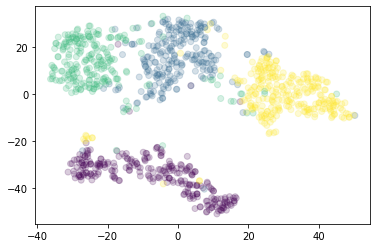

In [5]:
import numpy as np
import matplotlib.pyplot as plt

labels = {1, 2, 3, 4}
X_in_labels, y_in_labels = [], []
for xi, yi in zip(X, y):
    yi = np.argmax(yi)  # y is one-hot encoded.
    if yi in labels:
        X_in_labels.append(xi)
        y_in_labels.append(yi)
    if len(X_in_labels) == 1000:
      break

Z = get_relaxed_latent_projection(bm, np.array(X_in_labels))
plt.scatter(Z[:, 0], Z[:, 1], c=y_in_labels, alpha=0.2)
plt.show()

# Pruning

In [6]:
from boltzmann.generic.base import quantize

qbm = quantize(bm, 1e-1)
get_reconstruction_error(qbm, X[:5000])

<tf.Tensor: shape=(), dtype=float32, numpy=0.056889843>

In [7]:
qbm.latent_latent_kernel

<tf.Variable 'latent_latent_kernel:0' shape=(64, 64) dtype=float32, numpy=
array([[ 0., -3., -1., ...,  0., -2., -2.],
       [-3.,  0.,  4., ...,  1.,  0.,  5.],
       [-1.,  4.,  0., ...,  2.,  3.,  0.],
       ...,
       [ 0.,  1.,  2., ...,  0.,  0.,  0.],
       [-2.,  0.,  3., ...,  0.,  0.,  0.],
       [-2.,  5.,  0., ...,  0.,  0.,  0.]], dtype=float32)>

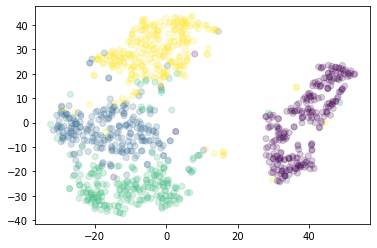

In [8]:
qZ = get_relaxed_latent_projection(qbm, np.array(X_in_labels))
plt.scatter(qZ[:, 0], qZ[:, 1], c=y_in_labels, alpha=0.2)
plt.show()